/tmp/ipython-input-2337879652.py:5: DtypeWarning: Columns (46,60) have mixed types. Specify dtype option on import or set low_memory=False.
  accident_df = pd.read_csv('/tmp/wsdotTrafficCollisionsFS.csv', parse_dates=['Collision Date'])
/tmp/ipython-input-2337879652.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  accident_df = pd.read_csv('/tmp/wsdotTrafficCollisionsFS.csv', parse_dates=['Collision Date'])


              precision    recall  f1-score   support

           0       0.38      0.36      0.37        36
           1       0.74      0.75      0.74        85

    accuracy                           0.64       121
   macro avg       0.56      0.56      0.56       121
weighted avg       0.63      0.64      0.63       121



/tmp/ipython-input-2337879652.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby('temp_category')['accident_count'].mean().plot(kind='bar', color='skyblue')


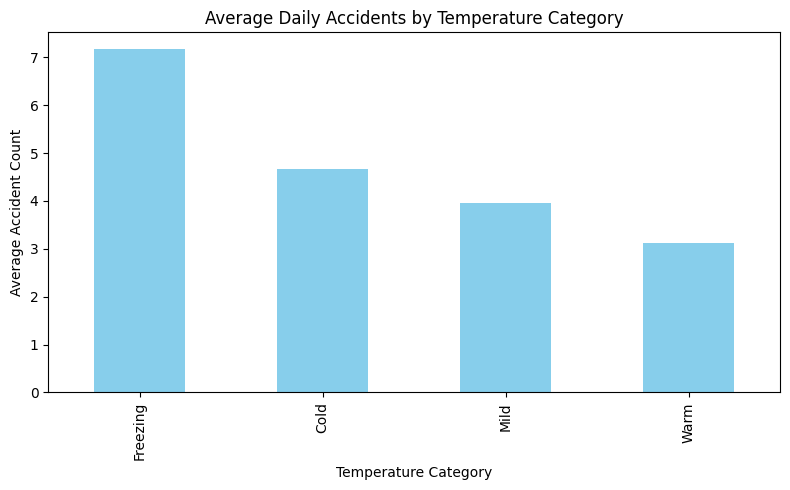

In [9]:
# Step 1: Load the Data
import pandas as pd

weather_df = pd.read_csv('/tmp/weatherstats_vancouver_daily.csv', parse_dates=['date'])
accident_df = pd.read_csv('/tmp/wsdotTrafficCollisionsFS.csv', parse_dates=['Collision Date'])

# Filter for 2024–2025
weather_df = weather_df[(weather_df['date'].dt.year >= 2024) & (weather_df['date'].dt.year <= 2025)]
accident_df = accident_df[(accident_df['Collision Date'].dt.year >= 2024) & (accident_df['Collision Date'].dt.year <= 2025)]

# Step 2: Preprocess and Merge
accident_daily = accident_df.groupby(accident_df['Collision Date'].dt.date).size().reset_index(name='accident_count')
accident_daily['date'] = pd.to_datetime(accident_daily['Collision Date'])

merged_df = pd.merge(weather_df, accident_daily[['date', 'accident_count']], on='date', how='left')
merged_df['accident_count'] = merged_df['accident_count'].fillna(0)

# Step 3: Feature Engineering
merged_df['is_rainy'] = merged_df['rain'] > 1
merged_df['is_snowy'] = merged_df['snow'] > 0
merged_df['temp_category'] = pd.cut(merged_df['avg_temperature'], bins=[-10, 0, 10, 20, 30], labels=['Freezing', 'Cold', 'Mild', 'Warm'])

features = merged_df[['avg_temperature', 'is_rainy', 'is_snowy']]
target = (merged_df['accident_count'] > 0).astype(int)

# Step 4: Train/Test Split and Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Step 5: Visualization with Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
merged_df.groupby('temp_category')['accident_count'].mean().plot(kind='bar', color='skyblue')
plt.title('Average Daily Accidents by Temperature Category')
plt.ylabel('Average Accident Count')
plt.xlabel('Temperature Category')
plt.tight_layout()
plt.show()

# Step 6: Interactive Visualization with Bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool

output_notebook()

source = ColumnDataSource(merged_df)

p = figure(x_axis_type='datetime', title='Accidents vs. Weather Over Time', height=400, width=700)
p.line('date', 'accident_count', source=source, color='firebrick', legend_label='Accidents')
p.line('date', 'rain', source=source, color='navy', legend_label='Rainfall (mm)')

hover = HoverTool(tooltips=[('Date', '@date{%F}'), ('Accidents', '@accident_count'), ('Rainfall', '@rain')],
                  formatters={'@date': 'datetime'})
p.add_tools(hover)

p.legend.location = 'top_left'
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Count / mm'

show(p)